<div dir="rtl">
ابتدا فایل json را می‌خوانیم و سپس برای هر خبر، title و summary و link و tags را در
لیست هایی به همین نام ذخیره می کنیم و سپس یک لیست برای دسته اصلی tags به نام main_tag ایجاد می‌کنیم.
</div>

In [1]:
import json
import hazm
with open('hamshahri.json') as f:
  data = json.load(f)
title = []
summary=[]
link = []
tags = []
main_tag = []
sum_tit = []
for item in data:
    title.append(item['title'])
    summary.append(item['summary'])
    link.append(item['link'])
    tags.append(item['tags'])
for i in range(len(summary)):
    sum_tit.append(summary[i] + " " + title[i])
for item in tags:
    s = item[0].replace("'",'')
    main_tag.append(s.split('>')[0])

<div dir="rtl">
از این تابع برای ساخت فایلی که نتیجه خوشه بندی را نشان می‌دهد استفاده می کنیم این تابع نام فایل و لیست لینک ها
 و برچسب مربوط به هر لینک را در یک لیست به عنوان ورودی دریافت کرده و فایل مورد نظر را می‌سازد.
</div>

In [2]:
import string
import csv
def create_csv(name,link,label):
    with open(name + ".csv", 'w+', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Link", "Label"])
        for i in range(len(link)):
            writer.writerow([link[i],label[i]])

<div dir="rtl">
از این تایع برای پیش پردازش متن استفاده می‌کنیم
و کلماتی که عدد و یا علائم نگارشی و یا جزو stop word فارسی باشند را از محموعه مستندات حذف می‌کنیم.
</div>

In [3]:
def clean_text(tokens):
    stop_word = hazm.stopwords_list()
    def is_not_clean(word):
        if word in string.punctuation:
            return False
        if word in '!٬٫﷼٪×،*)(ـ+=-][}{|»«:؛><؟/\\':
            return False
        if word.isdigit():
            return False
        if word in stop_word:
            return False
        if word == '':
            return False
        return True

    tokens = [value for value in tokens if is_not_clean(value)]
    return tokens

<div dir="rtl">
در این بخش برای title و summary به صورت جداگانه مستندات را به وسیله کتابخانه hazm پیش پردازش می‌کنیم.
</div>

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
title_word_list = []
title_doc_list = []
summary_doc_list = []
for item in title:
    normalizer = hazm.Normalizer()
    normalizer.normalize(item)
    title_word_list = hazm.word_tokenize(item)
    title_word_list = clean_text(title_word_list)
    stemmer = hazm.Stemmer()
    lemmatizer = hazm.Lemmatizer()
    for i in range(len(title_word_list)):
        title_word_list[i] = stemmer.stem(title_word_list[i])
        title_word_list[i] = lemmatizer.lemmatize(title_word_list[i])
    print("processing doc {} ".format(title.index(item) + 1))
    title_doc_list.append(title_word_list)
summary_word_list = []
for item in summary:
    normalizer = hazm.Normalizer()
    normalizer.normalize(item)
    summary_word_list = hazm.word_tokenize(item)
    summary_word_list = clean_text(summary_word_list)
    stemmer = hazm.Stemmer()
    lemmatizer = hazm.Lemmatizer()
    for i in range(len(summary_word_list)):
        summary_word_list[i] = stemmer.stem(summary_word_list[i])
        summary_word_list[i] = lemmatizer.lemmatize(summary_word_list[i])
    print("processing doc {} ".format(summary.index(item) + 1))
    summary_doc_list.append(summary_word_list)

processing doc 1 
processing doc 2 
processing doc 3 
processing doc 4 
processing doc 5 
processing doc 6 
processing doc 7 
processing doc 8 
processing doc 9 
processing doc 10 
processing doc 11 
processing doc 12 
processing doc 13 
processing doc 14 
processing doc 15 
processing doc 16 
processing doc 17 
processing doc 18 
processing doc 19 
processing doc 20 
processing doc 21 
processing doc 22 
processing doc 23 
processing doc 24 
processing doc 25 
processing doc 26 
processing doc 27 
processing doc 28 
processing doc 29 
processing doc 30 
processing doc 31 
processing doc 32 
processing doc 33 
processing doc 34 
processing doc 35 
processing doc 36 
processing doc 37 
processing doc 38 
processing doc 39 
processing doc 40 
processing doc 41 
processing doc 42 
processing doc 43 
processing doc 44 
processing doc 45 
processing doc 46 
processing doc 47 
processing doc 48 
processing doc 49 
processing doc 50 
processing doc 51 
processing doc 52 
processing doc 53 
pr

<div dir = "rtl">
در این بخش یک تابع dummy_fun که یک ورودی گرفته و همان را خروجی می‌دهد تعربف می‌کنیم از این تابع به عنوان tokenizer در
TfidfVectorizer استفاده می‌کنیم تا بتوانیم که به عنوان ورودی به آن، مستند tokenize شده را بدهیم.
</div>

In [6]:
print(title_doc_list)
print(summary_doc_list)
def dummy_fun(doc):
    return doc
tfidf = TfidfVectorizer(tokenizer=dummy_fun,preprocessor=dummy_fun,token_pattern=None,analyzer='word')

[['پرترافیک', 'جاده', 'ایر', 'پا', 'ممنوع', 'تردد', 'بین\u200cاستان'], ['کارو', 'حج', 'ش', 'تیر', 'اعزا'], ['ممنوع', 'تردد', 'استان', 'لغو'], ['نک', 'ضدکرونا', 'سفر', 'ضرور', 'رعا'], ['چطور', 'فهمید#فهم', 'ممنوع', 'الخروج', 'اطلاع', 'ممنوع', 'الخروج', 'فراه'], ['ممنوع', 'تردد', 'پلاک', 'غیربوم', 'ک', 'ادامه'], ['مرد', 'استان', 'نوروز', 'مازندر', 'سفر', 'تردد', 'چقدر', 'کاه'], ['پیشنهاد', 'وزیر', 'گردشگر', 'تعطیل', 'کرونا'], ['وضع', 'تردد', 'محور', 'برون', 'شهر', 'کشور', 'شبانه', 'روز', 'گذشته'], ['کاه', 'درصد', 'تردد', 'هزار', 'خودرو', 'شهر', 'مبدأ', 'بازنگشته\u200cاند'], ['کاه', 'درصد', 'سفر', 'روز', 'گذشته', '|\xa0', 'هزار', 'خودرو', 'آغاز', 'فاصله\u200cگذار', 'اجتماع', 'برگردانده'], ['چقدر', 'ترافیک', 'جاده', 'طرح', 'فاصله\u200cگذار', 'اجتماع', 'کم\xa0شد'], ['ممنوع', 'ورود', 'خودرو', 'پلاک', 'شهرس', 'تهر', '|\xa0توقیف', 'ماهه', 'خودرو', 'متخلف'], ['وضع', 'راه', 'بار', 'برف', 'بار', 'محور', 'اس'], ['خروج', 'خودرو', 'اس', 'تهر', 'ممنوع', 'خودرو', 'مستثن'], ['دقیقه', 'نفر', 'تصادف', 'ن

<div dir = "rtl">
در این بخش مستندات برای title و summary به صورت جداگانه از طریق TF-IDF به فضای برداری تبدیل می‌کنیم.
</div>

<div dir = "rtl">
توکن های موجود در title و summary برای هر مستند را concatenate کرده و در یک لیست دیگر به نام doc_list می‌ریزیم.
</div>

In [11]:
doc_list = []
for i in range(len(summary_doc_list)):
    doc_list.append(title_doc_list[i] + summary_doc_list[i])
print(doc_list)

[['پرترافیک', 'جاده', 'ایر', 'پا', 'ممنوع', 'تردد', 'بین\u200cاستان', 'رئیس', 'مرکز', 'اطلاع', 'کنترل', 'ترافیک', 'پلیس', 'راهور', 'ناجا', 'افزا', 'تردد', 'محور', 'مواصلات', 'اس', 'کشور', 'روز', 'اردیبه', 'خبر', 'رئیس', 'مرکز', 'اطلاع', 'کنترل', 'ترافیک', 'پلیس', 'راهور', 'ناجا', 'افزا', 'تردد', 'محور', 'مواصلات', 'اس', 'کشور', 'روز', 'اردیبه', 'خبر'], ['کارو', 'حج', 'ش', 'تیر', 'اعزا', 'معاون', 'حج', 'عمره', 'ساز', 'حج', 'زیار', 'اعلا', 'صور', 'عاد', 'شرایط', 'شیوع', 'ویروس', 'کرونا', 'کارو', 'زائر', 'حج', 'تمتع', 'ش', 'تیر', 'امسال\xa0راه', 'سرزمین', 'وح', 'شد#شو', 'معاون', 'حج', 'عمره', 'ساز', 'حج', 'زیار', 'اعلا', 'صور', 'عاد', 'شرایط', 'شیوع', 'ویروس', 'کرونا', 'کارو', 'زائر', 'حج', 'تمتع', 'ش', 'تیر', 'امسال\xa0راه', 'سرزمین', 'وح', 'شد#شو'], ['ممنوع', 'تردد', 'استان', 'لغو', 'رییس', 'مرکز', 'اطلاع', 'کنترل', 'ترافیک', 'پلیس', 'راهور', 'ناجا', 'لغو', 'ممنوع', 'تردد', 'بین\u200cاستان', 'کشور', 'خبر', 'رییس', 'مرکز', 'اطلاع', 'کنترل', 'ترافیک', 'پلیس', 'راهور', 'ناجا', 'لغو', 'ممنو

<div dir = "rtl">
در این بخش مستندات برای title و summary و
 هر دو با هم را به صورت جداگانه از طریق TF-IDF به فضای برداری تبدیل می‌کنیم.
</div>

In [55]:
print(type(summary_doc_list[0][0]))
title_X_TF_IDF = tfidf.fit_transform(title_doc_list)
title_weights = dict(zip(tfidf.get_feature_names(),tfidf.idf_))
print(tfidf.get_feature_names())
summary_X_TF_IDF = tfidf.fit_transform(summary_doc_list)
summary_weights = dict(zip(tfidf.get_feature_names(),tfidf.idf_))
X_TF_IDF = tfidf.fit_transform(doc_list)

<class 'str'>
['', '\r', '!!', '#ایران_همدل', '#سرباز', '#هست', ',٢', ',۳', '-\xa0اظهار', 'A', 'ADIZ', 'AFC', 'AP', 'Awards', 'BioNTech', 'Biotech', 'CNN', 'Cortona', 'ETF', 'FIR', 'GPS', 'Global', 'HBO', 'ICU', 'IKEA', 'IOC', 'Johnson', 'Moderna', 'Move', 'Music', 'NHS', 'O', 'OR۲', 'On', 'Oxford', 'Pfizer', 'Photos', 'Press', 'Remdesivir', 'SE', 'SE۲', 'Serum', 'Sinovac', 'TV', 'TV|', 'The', 'UVC', 'University', 'VPN', 'World', 'X', 'a', 'com', 'cspf', 'far', 'hammers', 'ir', 'iran-newspaper', 'mk۲', 'news', 'samanese', 'shadowed', 'www', '|5گل', '|\xa0', '|\xa0\xa0آیا', '|\xa0\xa0شیوع', '|\xa0اجاره', '|\xa0تاکید', '|\xa0توقیف', '|\xa0درآمد', '|\xa0س', '|\xa0می\u200cخواستند', '|\xa0ه', '|\xa0وارد', '|\xa0پایانه', '|\xa0پسر', '|دستیار', '|نکونا', '\xa0', '\xa0|', '\xa0ادرار', '\xa0با', '\xa0برا', '\xa0به', '\xa0بچه', '\xa0تاریخ', '\xa0تصاویر', '\xa0تغییر', '\xa0تکذیب', '\xa0در', '\xa0رادار', '\xa0طبیعتا', '\xa0مطرح', '\xa0موضوع', '\xa0نمی\u200cشود', '\xa0هفته', '\xa0پابرجاس', '\xa0که'

In [56]:
from gensim.models import Word2Vec
import numpy as np
title_X_word2vec = []
summary_X_word2vec = []
model = Word2Vec(title_doc_list,min_count=1,size=50,window=2)
for i in range(len(title_doc_list)):
    v = []
    sum_weight = 0
    for word in title_doc_list[i]:
        v.append(np.array(model.wv[word]))
        # sum_weight += title_weights[word]
    Sum = v[0]
    for j in range(1,len(v)):
        Sum += v[j]
    title_X_word2vec.append(np.array(Sum)/len(v))
model = Word2Vec(summary_doc_list,min_count=1,size=50,window=3)
for i in range(len(summary_doc_list)):
    v = []
    sum_weight = 0
    for word in summary_doc_list[i]:
        v.append(np.array(model.wv[word]))
        # sum_weight += summary_weights[word]
    Sum = v[0]
    for j in range(1,len(v)):
        Sum += v[j]
    summary_X_word2vec.append(np.array(Sum)/len(v))
X_word2vec = np.concatenate([np.array(title_X_word2vec),np.array(summary_X_word2vec)],axis=1)

In [77]:
from gensim.models import Word2Vec
import numpy as np
title_X_word2vec = []
summary_X_word2vec = []
model = Word2Vec(title_doc_list,min_count=1,size=100)
for i in range(len(title_doc_list)):
    v = []
    sum_weight = 0
    for word in title_doc_list[i]:
        v.append(np.array(model.wv[word]))
    v_min = np.amin(v,axis=0)
    v_max = np.amax(v,axis=0)
    title_X_word2vec.append(np.concatenate([v_min,v_max]))
model = Word2Vec(summary_doc_list,min_count=1,size=100)
for i in range(len(summary_doc_list)):
    v = []
    sum_weight = 0
    for word in summary_doc_list[i]:
        v.append(np.array(model.wv[word]))
    v_min = np.amin(v,axis=0)
    v_max = np.amax(v,axis=0)
    summary_X_word2vec.append(np.concatenate([v_min,v_max]))
X_word2vec = np.concatenate([np.array(title_X_word2vec),np.array(summary_X_word2vec)],axis=1)

In [63]:
from gensim.test.utils import common_texts
print(common_texts)
a = np.array([[1,2,3],[3,4,5]])
b = np.array([[6,7,8],[9,10,11]])
print(np.array([1,2,3])+np.array([1,2,3]))
print(np.concatenate([a,b],axis=1))

[['human', 'interface', 'computer'], ['survey', 'user', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'system'], ['system', 'human', 'system', 'eps'], ['user', 'response', 'time'], ['trees'], ['graph', 'trees'], ['graph', 'minors', 'trees'], ['graph', 'minors', 'survey']]
[2 4 6]
[[ 1  2  3  6  7  8]
 [ 3  4  5  9 10 11]]


<div dir = "rtl">
الگوریتم kmeans را برای TF-IDF و word2vec اجرا می‌کنیم
 و تعداد خوشه ها را  ۱۴ که تعداد unique دسته اصلی است قرار می‌دهیم.
</div>

[ 7  8  7  9 12  6  5  8  7  6 11 11  6 12  6]
v_measure_score: 0.0806
adjusted_rand_score : 0.0351
adjusted_mutual_info_score: 0.0641
rand_score : 0.7769
mutual_info_score: 0.1811


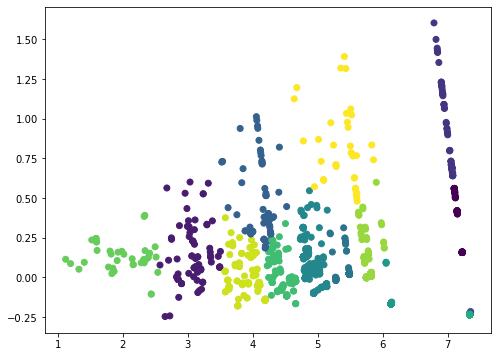

In [71]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
def Kmeans(X,name):
    km = KMeans(
        n_clusters=14, init='random',
        n_init=20
    )
    y_km = km.fit_predict(X)
    print(y_km[0:15])
    print("v_measure_score: %.4f" %v_measure_score(main_tag,y_km))
    print("adjusted_rand_score : %.4f" %metrics.adjusted_rand_score(main_tag,y_km))
    print("adjusted_mutual_info_score: %.4f" %metrics.adjusted_mutual_info_score(main_tag,y_km))
    print("rand_score : %.4f" %metrics.rand_score(main_tag,y_km))
    print("mutual_info_score: %.4f" %metrics.mutual_info_score(main_tag,y_km))
    create_csv(name,link,y_km)
    tsvd = TruncatedSVD(n_components=2)
    data_2D= tsvd.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(data_2D[:,0], data_2D[:,1], c=y_km.astype(float))
tsvd = TruncatedSVD(n_components=100,n_iter=10)
X_TF_IDF_tsvd = tsvd.fit_transform(X_TF_IDF)
Kmeans(X_TF_IDF_tsvd,"tf-idf_kmeans")
Kmeans(X_word2vec,"word2vec_kmeans")

<div dir = "rtl">
الگوریتم GMM را برای TF-IDF اجرا می‌کنیم
 و تعداد خوشه ها را  ۱۴ که تعداد unique دسته اصلی است قرار می‌دهیم.
 از svd برای کاهش بعد بردار ویژگی ها استفاده می‌کنیم.
</div>

v_measure_score: 0.2991
adjusted_rand_score : 0.1067
adjusted_mutual_info_score: 0.2858
rand_score : 0.7361
mutual_info_score: 0.6223


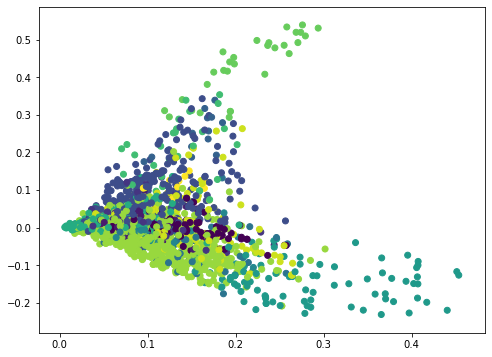

In [60]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=14, random_state=0).fit(X_TF_IDF_tsvd)
y_gm = gm.predict(X_TF_IDF_tsvd)
print("v_measure_score: %.4f" %v_measure_score(main_tag,y_gm))
print("adjusted_rand_score : %.4f" %metrics.adjusted_rand_score(main_tag,y_gm))
print("adjusted_mutual_info_score: %.4f" %metrics.adjusted_mutual_info_score(main_tag,y_gm))
print("rand_score : %.4f" %metrics.rand_score(main_tag,y_gm))
print("mutual_info_score: %.4f" %metrics.mutual_info_score(main_tag,y_gm))
create_csv("tf-idf_gmm",link,y_gm)
tsvd = TruncatedSVD(n_components=2)
data_2D= tsvd.fit_transform(X_TF_IDF)
plt.figure(figsize=(8, 6))
plt.scatter(data_2D[:,0], data_2D[:,1], c=y_gm.astype(float))

<div dir = "rtl">
الگوریتم GMM را برای word2vec اجرا می‌کنیم
 و تعداد خوشه ها را  ۱۴ که تعداد unique دسته اصلی است قرار می‌دهیم.
</div>

v_measure_score: 0.0783
adjusted_rand_score : 0.0418
adjusted_mutual_info_score: 0.0614
rand_score : 0.7474
mutual_info_score: 0.1662


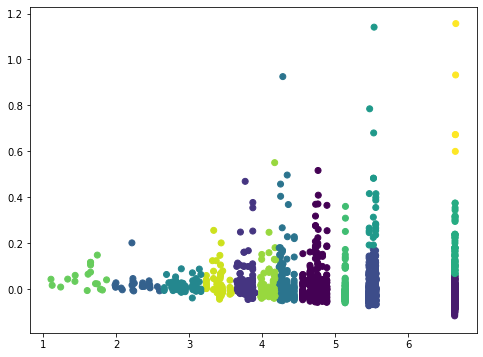

In [79]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=14, random_state=0).fit(X_word2vec)
y_gm = gm.predict(title_X_word2vec)
print("v_measure_score: %.4f" %v_measure_score(main_tag,y_gm))
print("adjusted_rand_score : %.4f" %metrics.adjusted_rand_score(main_tag,y_gm))
print("adjusted_mutual_info_score: %.4f" %metrics.adjusted_mutual_info_score(main_tag,y_gm))
print("rand_score : %.4f" %metrics.rand_score(main_tag,y_gm))
print("mutual_info_score: %.4f" %metrics.mutual_info_score(main_tag,y_gm))
create_csv("word2vec_gmm",link,y_gm)
tsvd = TruncatedSVD(n_components=2)
data_2D= tsvd.fit_transform(title_X_word2vec)
plt.figure(figsize=(8, 6))
plt.scatter(data_2D[:,0], data_2D[:,1], c=y_gm.astype(float))

<div dir = "rtl">
الگوریتم HAC را برای TF-IDF اجرا می‌کنیم
 و تعداد خوشه ها را  ۱۴ که تعداد unique دسته اصلی است قرار می‌دهیم.
</div>

v_measure_score: 0.2674
adjusted_rand_score : 0.0228
adjusted_mutual_info_score: 0.2524
rand_score : 0.6223
mutual_info_score: 0.5146


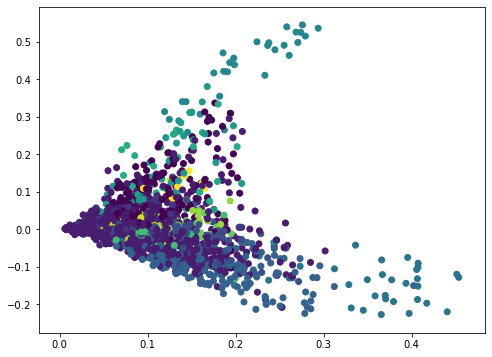

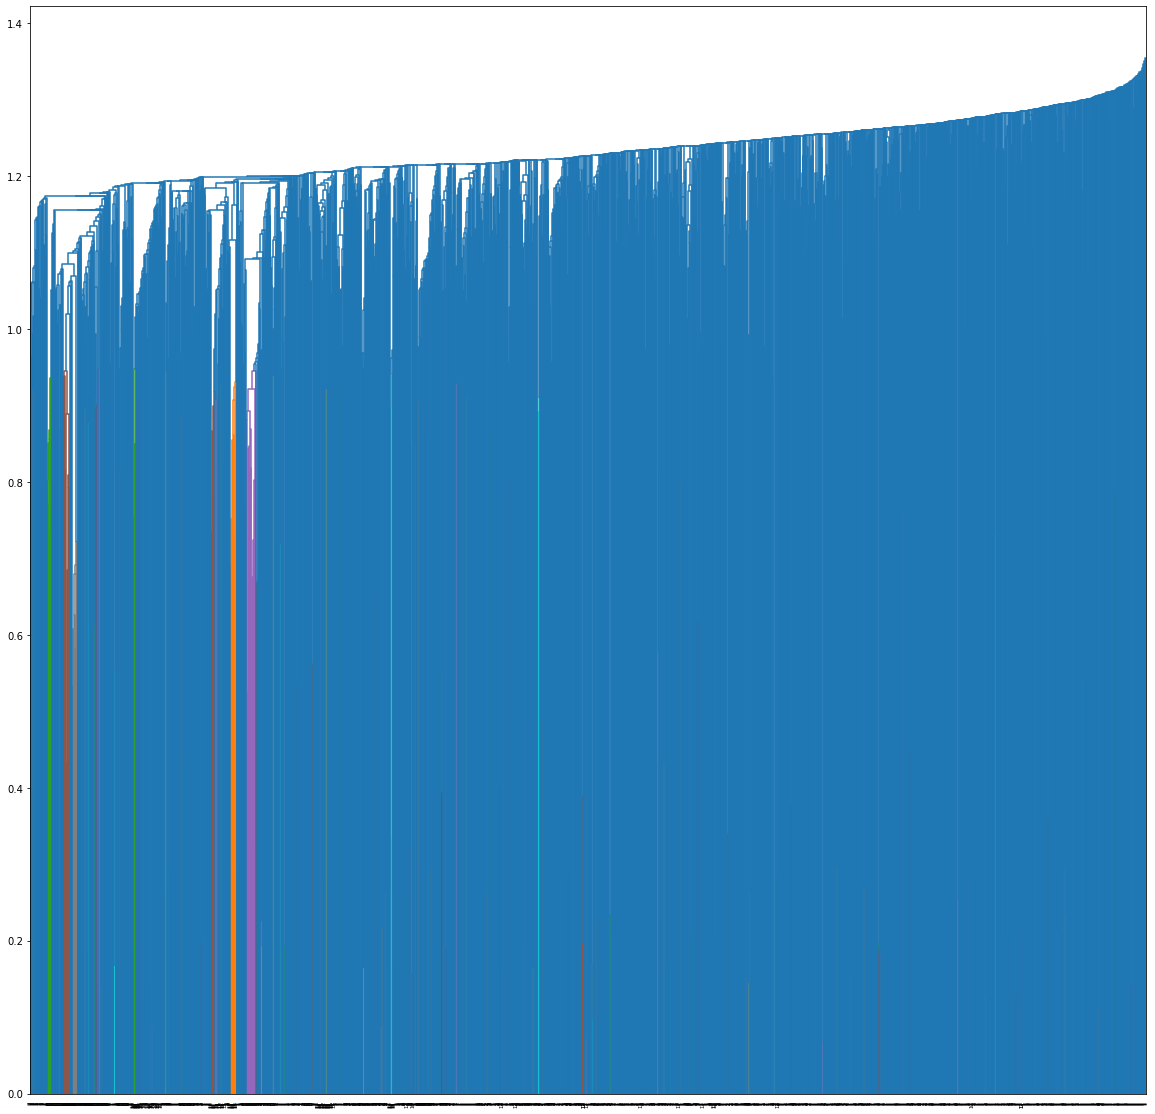

In [59]:
from sklearn.cluster import AgglomerativeClustering
y_hac = AgglomerativeClustering(n_clusters=14).fit_predict(X_TF_IDF_tsvd)
print("v_measure_score: %.4f" %v_measure_score(main_tag,y_hac))
print("adjusted_rand_score : %.4f" %metrics.adjusted_rand_score(main_tag,y_hac))
print("adjusted_mutual_info_score: %.4f" %metrics.adjusted_mutual_info_score(main_tag,y_hac))
print("rand_score : %.4f" %metrics.rand_score(main_tag,y_hac))
print("mutual_info_score: %.4f" %metrics.mutual_info_score(main_tag,y_hac))
create_csv("tf-idf_HAC",link,y_hac)
tsvd = TruncatedSVD(n_components=2)
data_2D= tsvd.fit_transform(X_TF_IDF)
plt.figure(figsize=(8, 6))
plt.scatter(data_2D[:,0], data_2D[:,1], c=y_hac.astype(float))

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X_TF_IDF.toarray(), 'single')


plt.figure(figsize=(20, 20))
dendrogram(linked,
            orientation='top',
            labels=y_hac,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

<div dir = "rtl">
الگوریتم HAC را برای word2vec اجرا می‌کنیم
 و تعداد خوشه ها را  ۱۴ که تعداد unique دسته اصلی است قرار می‌دهیم.
</div>

In [ ]:
from sklearn.cluster import AgglomerativeClustering
y_hac = AgglomerativeClustering(n_clusters=14).fit_predict(title_X_word2vec)
print("v_measure_score: %.4f" %v_measure_score(main_tag,y_hac))
print("adjusted_rand_score : %.4f" %metrics.adjusted_rand_score(main_tag,y_hac))
print("adjusted_mutual_info_score: %.4f" %metrics.adjusted_mutual_info_score(main_tag,y_hac))
print("rand_score : %.4f" %metrics.rand_score(main_tag,y_hac))
print("mutual_info_score: %.4f" %metrics.mutual_info_score(main_tag,y_hac))
create_csv("word2vec_HAC",link,y_hac)
tsvd = TruncatedSVD(n_components=2)
data_2D= tsvd.fit_transform(title_X_word2vec)
plt.figure(figsize=(8, 6))
plt.scatter(data_2D[:,0], data_2D[:,1], c=y_hac.astype(float))